# Caleb Corpuz 
# DSC 680 
# Project 1: Wallstreetbets Subreddit Analysis

In [1]:
# useful links

# https://realpython.com/python-nltk-sentiment-analysis/#using-nltks-pre-trained-sentiment-analyzer

# https://towardsdatascience.com/downloading-historical-stock-prices-in-python-93f85f059c1f  

In [2]:
import re
from re import search
import string
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer 
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('/Users/ccorpuz/Desktop/DSC 680/Data/reddit_wsb.csv')

In [4]:
#df.head(3)

### Cleaning and Processing Data

In [5]:
# Creates and indicator if some form of gamestop is present

def search_GME(data):
    if search("gme", data):
        x = 1
    elif search("gamestop", data):
        x = 1
    elif search("game stop", data):
        x = 1
    else:
        x = 0
    return x

In [6]:
df['title'] = df['title'].astype(str) 
df['title'] = df['title'].apply(lambda x: x.lower())

df['title_gme_ind'] = df['title'].apply(lambda x: search_GME(x)) # search the title for a form of GME

df['body'] = df['body'].astype(str)
df['body'] = df['body'].apply(lambda x: x.lower())

df['body_gme_ind'] = df['body'].apply(lambda x: search_GME(x)) # search the body for a form of GME

df['all_gme_ind'] = df['title_gme_ind'] + df['body_gme_ind'] # total the indicator columns 

# create a df that has all the posts containing some form of gamestop in either the title or body
df_gme = df[df['all_gme_ind'] > 0]

In [7]:
#df_gme.head(3)

In [8]:
# functions to clean text

stop_words = set(stopwords.words('english')) 

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_stopword(data):
    new_data = []
    for word in data:
        if word not in stop_words:
            new_data.append(word)
        else:
            continue
    return new_data

def retrieve_date(data): # pulls only the year, month, and day from the timestamp
    x = data[0:10]
    return x

In [9]:
# Is it necessary to tokenize text if we are using VADER?

# Clean title
df_gme['clean_title'] = df_gme['title'].apply(lambda x: remove_emoji(x))
df_gme['clean_title'] = df_gme['clean_title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_gme['title_token'] = df_gme['clean_title'].apply(lambda x: word_tokenize(x)) 
df_gme['title_token'] = df_gme['title_token'].apply(lambda x: remove_stopword(x)) 

# Clean body
df_gme['clean_body'] = df_gme['body'].apply(lambda x: remove_emoji(x))
df_gme['clean_body'] = df_gme['clean_body'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) 
df_gme['body_token'] = df_gme['clean_body'].apply(lambda x: word_tokenize(x))
df_gme['body_token'] = df_gme['body_token'].apply(lambda x: remove_stopword(x)) 

# Create data column that only uses the year month and day
df_gme['date'] = df_gme['timestamp'].apply(lambda x: retrieve_date(x))

df_gme = df_gme.reset_index()

<ipython-input-9-bcc131e22f37>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gme['clean_title'] = df_gme['title'].apply(lambda x: remove_emoji(x))
<ipython-input-9-bcc131e22f37>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gme['clean_title'] = df_gme['clean_title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
<ipython-input-9-bcc131e22f37>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [10]:
# Sentiment analysis using VADER
sia = SentimentIntensityAnalyzer()

# Create columns for sentiment polarity scores
df_gme['title_sia'] = df_gme['clean_title'].apply(lambda x: sia.polarity_scores(x))
df_gme['body_sia'] = df_gme['clean_body'].apply(lambda x: sia.polarity_scores(x))

#Retrieve only the compound score
def retrieve_sia(data):
    x = data['compound']
    return x

# Create columns for the compound sia
df_gme['title_compound_sia'] = df_gme['title_sia'].apply(lambda x: retrieve_sia(x))
df_gme['body_compound_sia'] = df_gme['body_sia'].apply(lambda x: retrieve_sia(x))


# Full text (title and body combined)
df_gme['full_text'] = df_gme['clean_title'] + ' ' + df_gme['clean_body']
df_gme['full_token'] = df_gme['title_token'] + df_gme['body_token']
df_gme['full_sia'] = df_gme['full_text'].apply(lambda x: sia.polarity_scores(x))
df_gme['full_compound_sia'] = df_gme['full_sia'].apply(lambda x: retrieve_sia(x))

In [11]:
# Clean up the dataframe

df_gme_final = df_gme.drop(columns = ['index','title_gme_ind', 'body_gme_ind', 'all_gme_ind',
                                      'id', 'score', 'url', 'comms_num', 'created', 'timestamp'])

df_gme_final = df_gme_final.reset_index()

# optional columns to get rid of
#'title', 'body', 'title_token', 'body_token', 'full_text', 'full_sia'

In [71]:
#df_gme_final.head(3)

In [20]:
num_posts_df = df_gme_final.groupby(['date'])['title'].count().reset_index(name='num_posts')

In [21]:
num_posts_df = num_posts_df.reset_index()

In [72]:
#num_posts_df.head()

In [28]:
weekDays = ["Mon","Tues","Wed","Thur","Fri","Sat","Sun"]

def get_weekday(data):
    date1 = datetime.strptime(data, '%Y-%m-%d')
    date2 = date1.weekday()
    x = weekDays[date2]
    return x
    

In [29]:
df_gme_final['weekday'] = df_gme_final['date'].apply(lambda x: get_weekday(x))

In [176]:
weekday_posts = df_gme_final.groupby(['weekday'])['title'].count().reindex(weekDays).reset_index(name = "num_posts")

### Historical Stock Data via Yahoo Finance

In [33]:
avg_df = df_gme_final.groupby(['date'])['full_compound_sia'].mean().reset_index(name='Daily_Avg_Sia')

In [34]:
import yfinance as yf
import datetime
import time
import requests
import io

In [49]:
# Set the start and end dates of the date we want to pull
start = datetime.datetime(2021,1,28)
end = datetime.datetime(2021,3,17)

# Pull the data for GME
stock = yf.download('GME',start=start, end=end, progress=False)

In [50]:
stock_df = pd.DataFrame(stock)
stock_df = stock_df.reset_index()
stock_df['price_change'] = stock_df['Close'] - stock_df['Open']
#stock_df

In [51]:
def return_weekday(data):
    x = weekDays[data]
    return x

In [63]:
join_df = stock_df.join(avg_df) # join stock data and sentiment data
join_df = join_df.drop(columns = ['date'])
join_df_2 = join_df.join(num_posts_df) # bring in the number of posts
#join_df_2 = join_df.drop(columns = ['date'])
join_df_2['weekdaynum'] = join_df_2['Date'].apply(lambda x: x.weekday()) # retrieve the weekday number
join_df_2['weekday'] = join_df_2['weekdaynum'].apply(lambda x: return_weekday(x)) # retrieve weekday name
final_df = join_df_2.drop(columns = ['weekdaynum', 'date'])

In [73]:
#final_df.head()

In [65]:
final_df['sia_diff'] = final_df['Daily_Avg_Sia'].diff()

In [66]:
def direction_change(data):
    if data < 0:
        x = -1
    elif data == 0:
        x = 0
    else:
        x = 1
    return x

final_df['sia_direction'] = final_df['sia_diff'].apply(lambda x: direction_change(x))
final_df['price_direction'] = final_df['price_change'].apply(lambda x: direction_change(x))

In [68]:
#final_df

In [ ]:
final_df.to_csv('/Users/ccorpuz/Desktop/DSC 680/reddit_stock_df.csv')

### How does reddit posts relate to stock data?

In [70]:
final_df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,price_change,Daily_Avg_Sia,index,num_posts,weekday,sia_diff,sia_direction,price_direction
0,2021-01-28,265.000000,483.000000,112.25,193.600006,193.600006,58815800,-71.399994,0.007803,0,458,Thur,NaN,1,-1
1,2021-01-29,379.709991,413.980011,250.00,325.000000,325.000000,50259200,-54.709991,0.008818,1,4995,Fri,0.001015,1,-1
2,2021-02-01,316.559998,322.000000,212.00,225.000000,225.000000,37382200,-91.559998,0.240263,2,600,Mon,0.231446,1,-1


## EDA

### What are the most common words?

In [193]:
full_corpus = []

def retrieve_corpus(data):
    for w in data:
        full_corpus.append(w)
        
df_gme['full_token'].apply(lambda x: retrieve_corpus(x))

full_corpus[0:5]

['math', 'professor', 'scott', 'steiner', 'says']

In [196]:
from nltk import FreqDist

print("The top 10 most common words are:")
freq_dist_pos = FreqDist(full_corpus)
for i in freq_dist_pos.most_common(10): # Top 10 most common words
    print(i)

The top 10 most common words are:
('gme', 21494)
('shares', 8393)
('stock', 7885)
('short', 7481)
('buy', 7062)
('price', 6494)
('like', 6445)
('market', 6280)
('im', 6235)
('dont', 5750)


### Sentiment vs Stock Price

In [169]:
sia1 = final_df['Daily_Avg_Sia']
sia_diff = final_df['sia_diff']
price = final_df['Close']
price_change = final_df['price_change']
date = final_df['Date']
index = final_df['index']

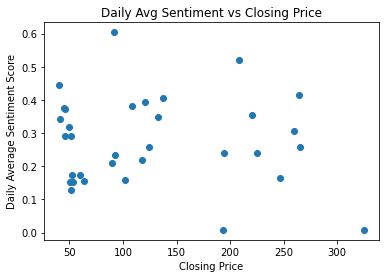

In [206]:
plt.scatter(x = final_df['Close'], y = final_df['Daily_Avg_Sia'])
plt.xlabel("Closing Price")
plt.ylabel("Daily Average Sentiment Score")
plt.title("Daily Avg Sentiment vs Closing Price")
plt.show()

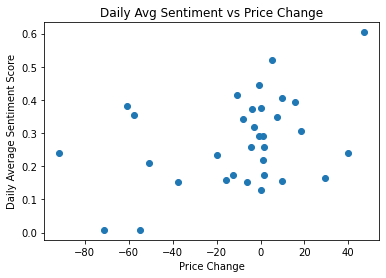

In [172]:
plt.scatter(x = final_df['price_change'], y = final_df['Daily_Avg_Sia'])
plt.xlabel("Price Change")
plt.ylabel("Daily Average Sentiment Score")
plt.title("Daily Avg Sentiment vs Price Change")
plt.show()

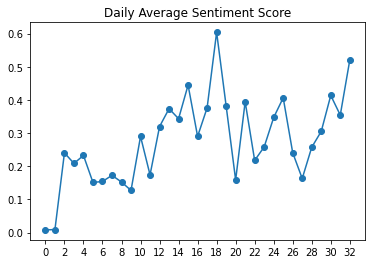

In [82]:
plt.plot(index, sia1)
plt.scatter(index, sia1)
plt.title("Daily Average Sentiment Score")
plt.locator_params(axis="x", nbins=33)
plt.show()

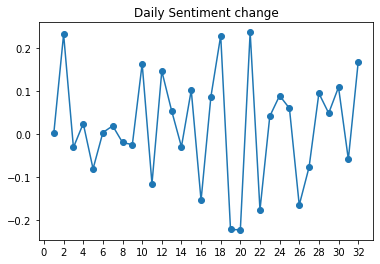

In [168]:
plt.plot(index, sia_diff)
plt.scatter(index, sia_diff)
plt.title("Daily Sentiment change")
plt.locator_params(axis="x", nbins=33)
plt.show()

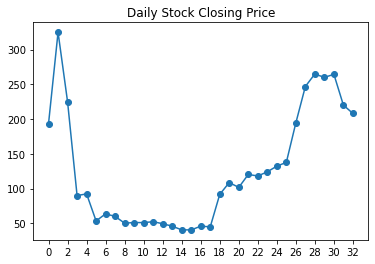

In [171]:
plt.plot(index, price)
plt.scatter(index, price)
plt.title("Daily Stock Closing Price")
plt.locator_params(axis="x", nbins=33)
plt.show()

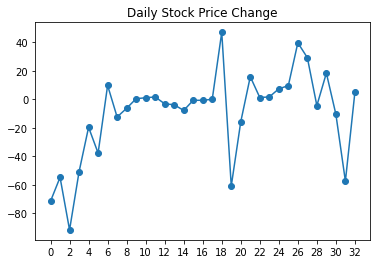

In [84]:
plt.plot(index, price_change)
plt.scatter(index, price_change)
plt.title("Daily Stock Price Change")
plt.locator_params(axis="x", nbins=33)
plt.show()

### Number of Posts vs Volume

In [145]:
#no_outlier_df = df_gme_final[df_gme_final['date'] != '2021-01-29']

In [178]:
weekday_volume = final_df.groupby(['weekday'])['Volume'].sum().reindex(weekDays).reset_index(name = "Volume")

In [159]:
no_outlier_2 = final_df[final_df['Date'] != '2021-01-29']

In [149]:
weekday_posts = df_gme_final.groupby(['weekday'])['title'].count().reindex(weekDays).reset_index(name = "num_posts")

In [150]:
weekday_volume = final_df.groupby(['weekday'])['Volume'].sum().reindex(weekDays).reset_index(name = "Volume")

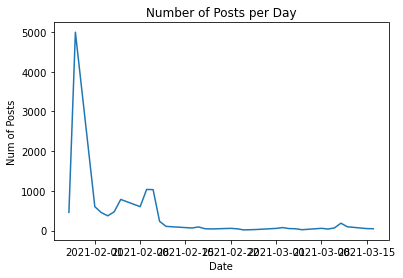

In [165]:
plt.plot(final_df['Date'], final_df['num_posts'])
plt.xlabel("Date")
plt.ylabel("Num of Posts")
plt.title("Number of Posts per Day")
plt.show()

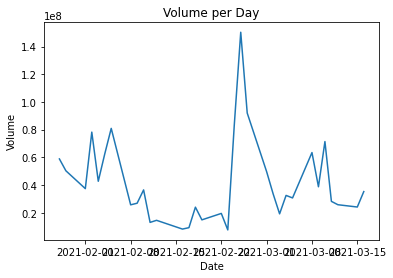

In [167]:
plt.plot(final_df['Date'], final_df['Volume'])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume per Day")
plt.show()

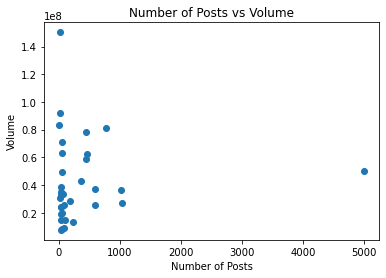

In [151]:
#remove_outlier = final_df[final_df['num_posts'] < 4000]
plt.scatter(x = final_df['num_posts'], y = final_df['Volume'])
plt.xlabel("Number of Posts")
plt.ylabel("Volume")
plt.title("Number of Posts vs Volume")
plt.show()

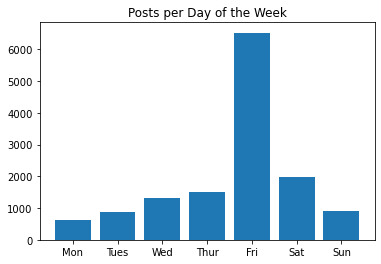

Number of Posts by Weekday:
  weekday  num_posts
0     Mon        623
1    Tues        869
2     Wed       1317
3    Thur       1518
4     Fri       6520
5     Sat       1986
6     Sun        911


In [173]:
plt.bar(height = weekday_posts['num_posts'], x = weekday_posts['weekday'])
plt.title("Posts per Day of the Week")
plt.show()

print("Number of Posts by Weekday:")
print(weekday_posts)

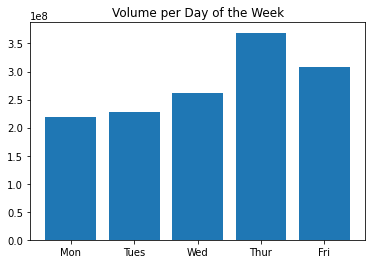

Volume by Weekday:
  weekday       Volume
0     Mon  219668000.0
1    Tues  228374500.0
2     Wed  261987600.0
3    Thur  369199500.0
4     Fri  308855600.0


In [181]:
plt.bar(height = weekday_volume['Volume'], x = weekday_volume['weekday'])
plt.title("Volume per Day of the Week")
plt.show()

print("Volume by Weekday:")
print(weekday_volume[0:5])

In [ ]:
# There seems to be some similarities in the trends. Maybe a lagged relationship? I know how to 
# use lags in R so maybe export the data to R, lag a variable, then run a regression. Create a lag for 1 through
# 5 days and see which has the best correlation

#### Possible Research Questions:

- How does the post sentiment relate to GME stock?
- Does sentiment correlate with stock price?
- Does the volume of posts on a given day show more change in the price or the volume of trades?
- does day of the week affect sentiment?


In [ ]:
# To look at the correlation between the reddit posts and stock data, I ran the following code in R. 

r_code = '''
library(tidyverse)

rm(list=ls())

reddit_df <- read.csv('/Users/ccorpuz/Desktop/DSC 680/reddit_stock_df.csv')

df <- reddit_df %>%
  transmute(
    date = as.Date(Date),
    Daily_Avg_Sia = Daily_Avg_Sia,
    close = Close,
    close_lag1 = lag(close, 1),
    close_lag2 = lag(close, 2),
    close_lag3 = lag(close, 3),
    close_lag4 = lag(close, 4),
    close_lag5 = lag(close, 5),
    sia_diff = sia_diff,
    sia_diff_Lag1 = lag(sia_diff, 1),
    sia_diff_Lag2 = lag(sia_diff, 2),
    sia_diff_Lag3 = lag(sia_diff, 3),
    sia_diff_Lag4 = lag(sia_diff, 4),
    sia_diff_Lag5 = lag(sia_diff, 5),
    price_change = price_change,
    price_change_Lag1 = lag(price_change, 1),
    price_change_Lag2 = lag(price_change, 2),
    price_change_Lag3 = lag(price_change, 3),
    price_change_Lag4 = lag(price_change, 4),
    price_change_Lag5 = lag(price_change, 5),
    Volume = Volume,
    Volume_lag1 = lag(Volume, 1),
    Volume_lag2 = lag(Volume, 2),
    Volume_lag3 = lag(Volume, 3),
    Volume_lag4 = lag(Volume, 4),
    Volume_lag5 = lag(Volume, 5),
    num_posts = num_posts
    
  )

ggplot(df, aes(x = date, y = Daily_Avg_Sia)) + 
  geom_point() + 
  geom_line() + 
  ggtitle("Daily Average Sentiment Score")

ggplot(df, aes(x = date, y = price_change)) + 
  geom_point() + 
  geom_line() + 
  ggtitle("Daily Price Change")

### Correlation between sentiment and price #######################################################
cor(df$Daily_Avg_Sia, df$close, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$close_lag1, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$close_lag2, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$close_lag3, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$close_lag4, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$close_lag5, use = "pairwise.complete.obs", method = "pearson")

### Correlation between sentiment and price change ################################################

cor(df$Daily_Avg_Sia, df$price_change, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$price_change_Lag1, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$price_change_Lag2, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$price_change_Lag3, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$price_change_Lag4, use = "pairwise.complete.obs", method = "pearson")
cor(df$Daily_Avg_Sia, df$price_change_Lag5, use = "pairwise.complete.obs", method = "pearson")

### Correlation between sentiment change and price change #########################################

cor(df$sia_diff, df$price_change, use = "pairwise.complete.obs", method = "pearson")
cor(df$sia_diff, df$price_change_Lag1, use = "pairwise.complete.obs", method = "pearson")
cor(df$sia_diff, df$price_change_Lag2, use = "pairwise.complete.obs", method = "pearson")
cor(df$sia_diff, df$price_change_Lag3, use = "pairwise.complete.obs", method = "pearson")
cor(df$sia_diff, df$price_change_Lag4, use = "pairwise.complete.obs", method = "pearson")
cor(df$sia_diff, df$price_change_Lag5, use = "pairwise.complete.obs", method = "pearson")


### Correlation between number of posts and volume ################################################

cor(df$num_posts, df$Volume, use = "pairwise.complete.obs", method = "pearson")
cor(df$num_posts, df$Volume_lag1, use = "pairwise.complete.obs", method = "pearson")
cor(df$num_posts, df$Volume_lag2, use = "pairwise.complete.obs", method = "pearson")
cor(df$num_posts, df$Volume_lag3, use = "pairwise.complete.obs", method = "pearson")
cor(df$num_posts, df$Volume_lag4, use = "pairwise.complete.obs", method = "pearson")
cor(df$num_posts, df$Volume_lag5, use = "pairwise.complete.obs", method = "pearson")

'''


### Things to include


- How many times the terms "buy" and "sell" occurs in a day



